# Radioastronomia 1 2017/18
## Sprawozdanie - ćw. 3
## Obserwacja rozciągłego obszaru promieniowania radiowego i opracowanie mapy
### Dawid Kubicki

## Wstęp

Ćwiczenie przeprowadzono 8 listopada 2017 w Obserwatorium Astronomicznym UJ przy radioteleskopie RT-15. Celem ćwiczenia było stworzenie mapy radiowej fragmentu Drogi Mlecznej. 

## Przebieg ćwiczenia

Zdecydowano się na skan wokół Cas A. Wynika to międzyinnymi z faktu, że w trakcie obserwacji ten fragment Galaktyki był blisko zenitu. Ponadto Cas A jest źródłem o dobrze zbadanym strumieniu, a więc nadaje się do kalibracji.

Postanowiono wykonać mapę o rozmiarach około $5^\circ x 5^\circ$. Podczas wykonywania ćwiczenia należało pamiętać, że kąt godzinny obiektów zmienia się w czasie. Pomiar wykonywano skanując w kącie godzinnym na szerokość około $1^h$ (co na zadanej deklinacji odpowiada około $7^\circ$, czyli trochę więcej niż chcemy uzyskać, co zabezpiecza nas na wypadek lekkiej pomyłki). Co skan zmieniano deklinację o około $15'$. Na początku i końcu pomiarów wykonano kalibrację z tłumieniem 10dB. Ze względu na przekroczenie dopuszczalnego rozmiaru pliku z danymi wykonano o kilka mniej skanów niż planowano. 


## Opracowanie

Najpierw bardzo wstępnie przyjrzymy się danym - jak zmieniał się sygnał, rekstasencja i deklinacja w czasie. 

18184


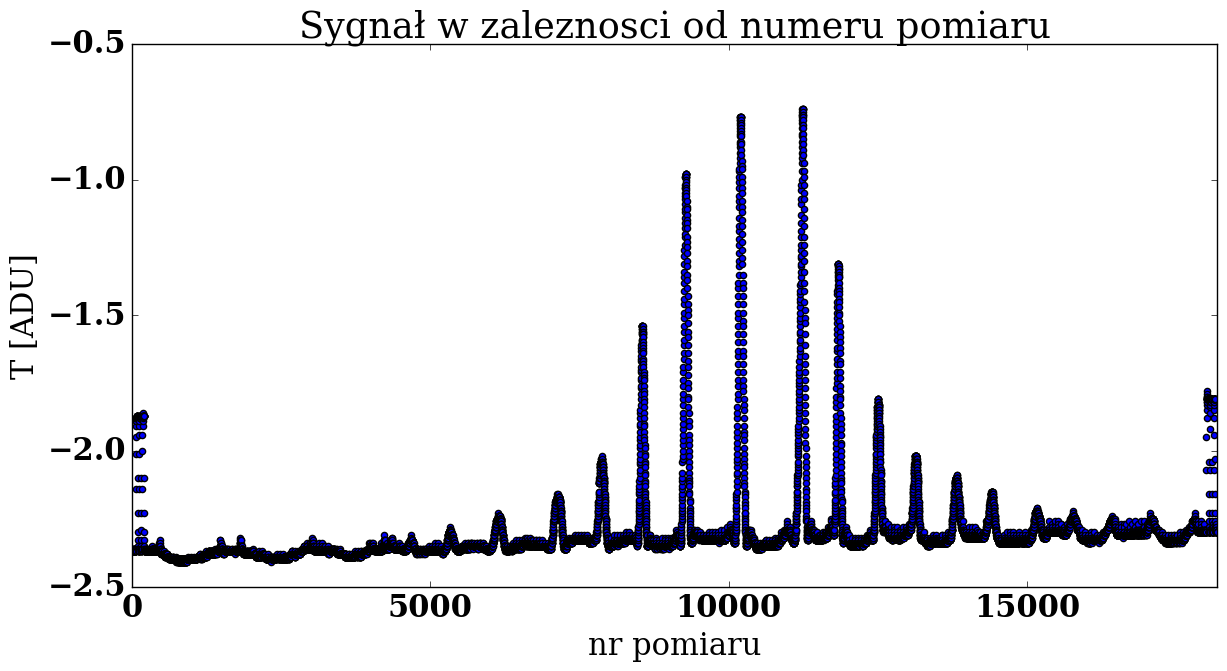

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

def load_data(filename):
    with open(filename) as f:
        res = []
        for line in f:
            res.append(line.split())
        return np.array(res).astype(np.float)
    
data = load_data('/home/dawid/radioastronomy/3/CASARD1.txt')
data_count = len(data)
print(data_count)
sig = np.array([d[2] for d in data])
nr = np.arange(data_count)

plt.figure(figsize=(14, 7))
plt.scatter(nr, sig)
plt.xlim([0,data_count])
plt.title("Sygnał w zaleznosci od numeru pomiaru")
plt.xlabel("nr pomiaru")
plt.ylabel("T [ADU]")
plt.show()    


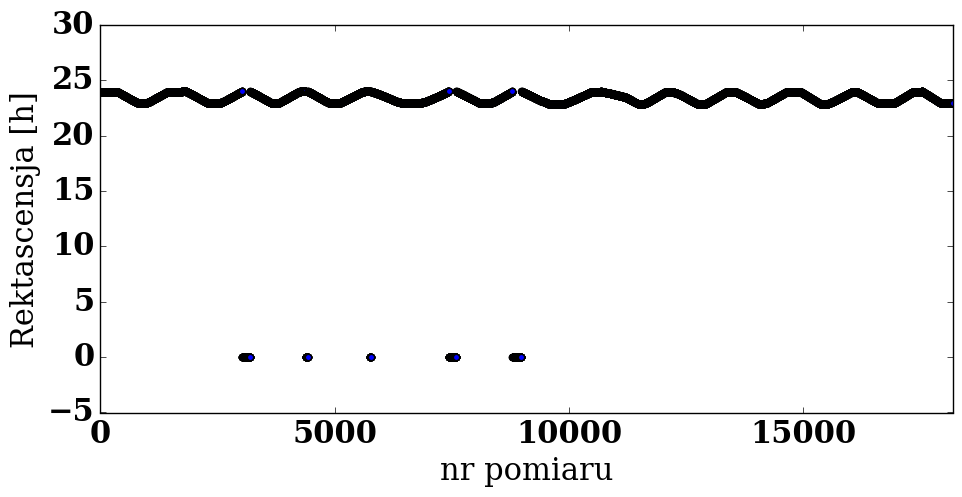

In [5]:
ra = np.array([d[0] for d in data])

plt.figure(figsize=(11, 5))
plt.scatter(nr, ra)
plt.xlim([0,data_count])
plt.xlabel("nr pomiaru")
plt.ylabel("Rektascensja [h]")
plt.show()    

Widzimy, że czasami rektascensja przekraczała $24^h$. Dla prostoty obliczeń do tych pomiarów dodamy $24^h$.

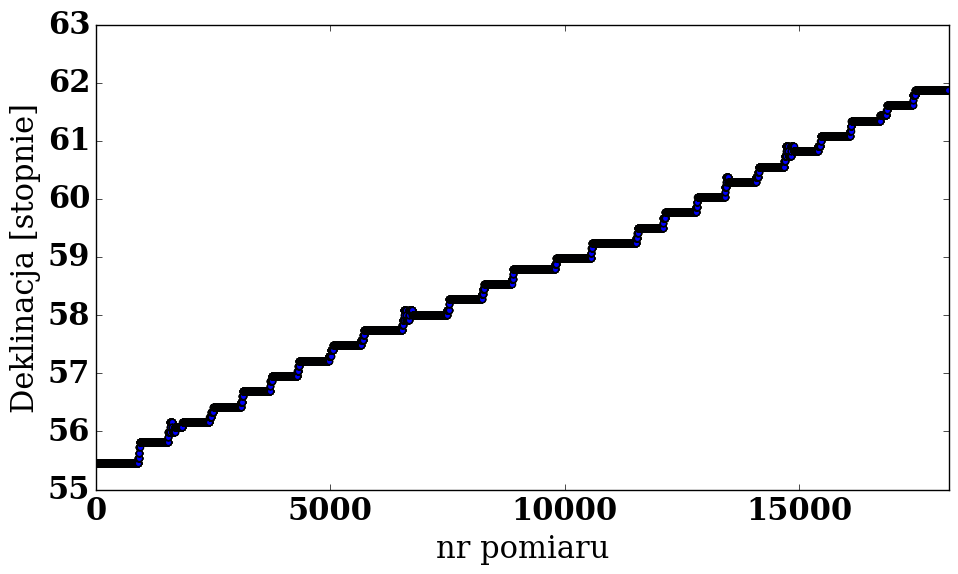

In [6]:
dec = np.array([d[1] for d in data])

plt.figure(figsize=(11, 6))
plt.scatter(nr, dec)
plt.xlim([0,data_count])
plt.xlabel("nr pomiaru")
plt.ylabel("Deklinacja [stopnie]")
plt.show()    

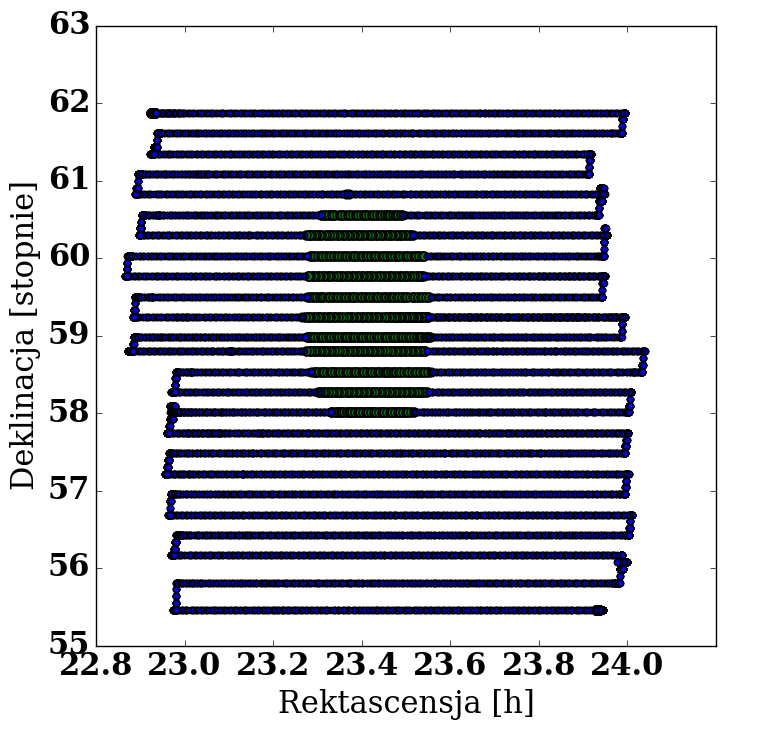

In [7]:
ra[ra < 12] += 24
ind_casa = sig > -2.22

plt.figure(figsize=(8, 8))
plt.scatter(ra[ind_casa], dec[ind_casa], c='g', s=40)
plt.scatter(ra[~ind_casa], dec[~ind_casa], c='b')
plt.xlabel("Rektascensja [h]")
plt.ylabel("Deklinacja [stopnie]")
plt.show()


Powyżej na wykresie zielonymi powiększonymi punktami oznaczono te wyniki pomiaru, dla których sygnał był większy od $-2.22 ADU$. W praktyce okazuje się, że jest to tylko otoczenie Cas A.

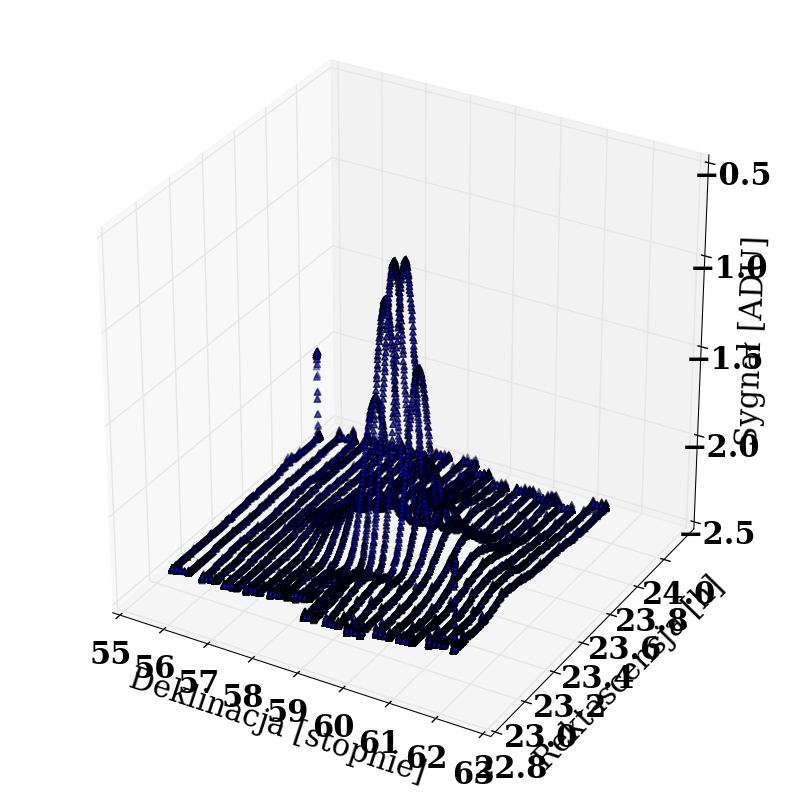

In [8]:
#Aby wykres był interaktywny należy zmienić w pierwszej linijce kodu w notebooku
#%matplotlibl inline% na matplotlib notebook i zrestartować kernel
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(dec, ra, sig, c='b', marker='^')

ax.set_xlabel('Deklinacja [stopnie]')
ax.set_ylabel('Rektascensja [h]')
ax.set_zlabel('Sygnał [ADU]')

plt.show()

Przejdziemy teraz do opracowania danych. Po pierwsze korzystając z kalibracji przeliczymy $ADU$ na kelwiny. Następnie dopasujemy dwuwymiarową funkcję Gaussa do sygnału z Cassiopei A, i znając jej strumień z programu OOD przeliczymy $ADU$ na $Jy$. 

In [9]:
import scipy.optimize as opt
import numpy as np
import pylab as plt


def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    x, y = xy
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()


initial_guess = (1.7, 58.9358, 23.403055, 1, 0.1, 0.05, -2.4)
ind = (dec > 57.5) & (dec < 60.7) & (ra > 23.25) & (ra < 23.6) 
x = dec[ind]
y = ra[ind]
z = sig[ind]

fit_params, fit_cov = opt.curve_fit(twoD_Gaussian, (x, y), z, p0=initial_guess)
fit_err = np.sqrt(np.diag(fit_cov))
print(fit_params, fit_err)

from IPython.display import display, HTML

def df_to_html(df, format = "{:.4f}"):
    styles = [
        dict(selector="th", props=[("font-size", "110%"), ("text-align", "center")]),
        dict(selector="td", props=[("text-align", "center")])
    ]
    html = df.style.set_table_styles(styles).format(format).render()
    return html


df_index = ['Wartosc', 'Niepewnosc dopasowania']
df_cols = ['Amplituda [ADU]', 'Dec srednie [°]', 'Ra srednie [h]', 'Sigma dec [°]', 'Sigma ra [h]',
           'Theta [rad]', 'Przesuniecie [ADU]']
df1 = pd.DataFrame(data=[fit_params, fit_err],
                   columns=df_cols,
                   index=df_index)

HTML(df_to_html(df1))

[  1.58415479e+00   5.90918869e+01   2.34120337e+01   4.57085439e-01
   6.20110541e-02   4.58782325e-03  -2.26696173e+00] [ 0.00575951  0.00178271  0.00022195  0.00211154  0.0002591   0.00075755
  0.00197966]


Otrzymujemy funkcję Gaussa o amplitudzie $$A = 1.584 \pm 0.006 ADU$$ Z otrzymanych parametrów można też otrzymać oszacowanie parametrów listka głównego (podobnie jak w ćw. 2a, ale tam dopasowywano jednowymiarowe funkcje Gaussa). 

Z programu OOD odczytujemy strumień Cas A w dniu obserwacji $$S_v = 1462.4 Jy$$. 

In [10]:
sv = 1462.4
A = 1.584
dA = 0.006
p = sv/A
dp = sv/(A**2)*dA
print(p, dp)

923.2323232323232 3.49709213345577


Co daje przelicznik $$p = 923.2 \pm 3.5 \frac{Jy}{ADU}$$. W instrukcji jesteśmy również proszeni o przeliczenie z ADU na kelwiny. Wydaje się to nadmiarowe, ale dla kompletności zostanie policzone poniżej.

Kalibrację (z dodatkowym $10dB$ tłumieniem) wykonano na początku i końcu pomiaru. Wyznaczymy współczynniki na podstawie obu z nich, a następnie policzymy średnią ważoną.

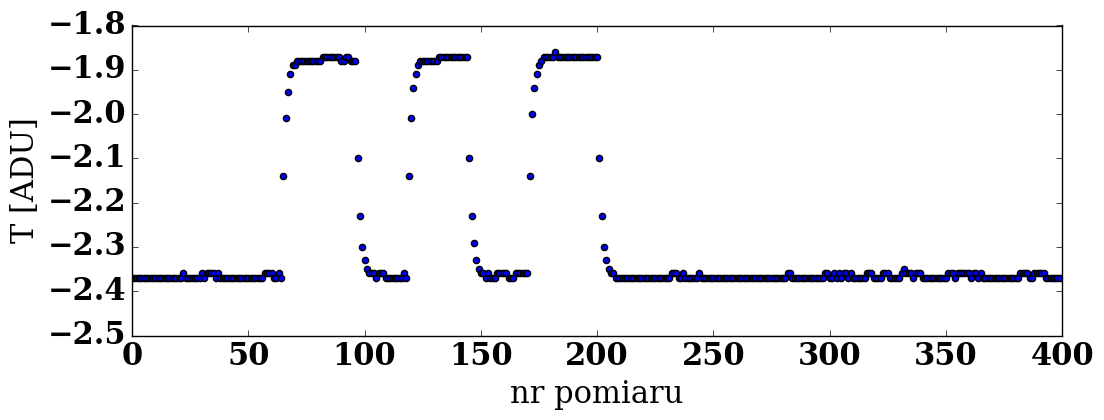

17.5292041078 0.337038232894


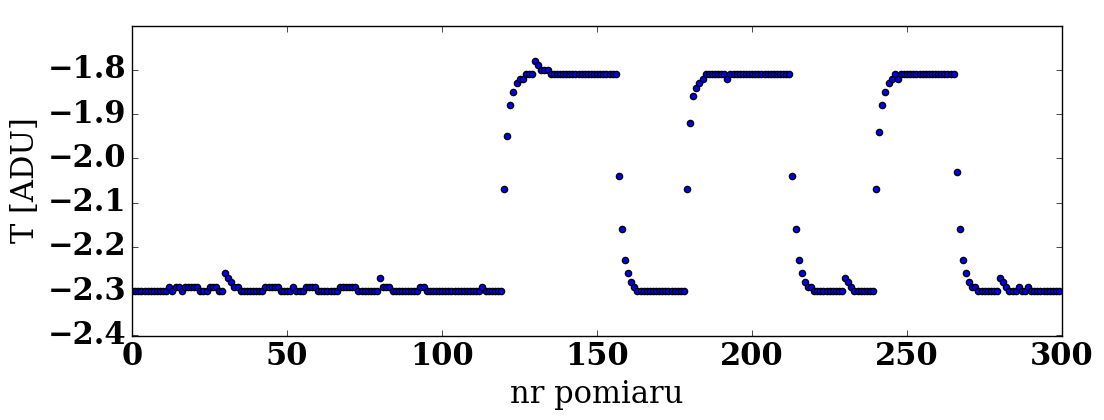

17.8286367098 0.266290085685
17.7135565344 0.2089439903868313


In [11]:
cal_start = data[:400]
cal_sig = np.array([d[2] for d in cal_start])
nr = np.arange(len(cal_sig))

plt.figure(figsize=(12, 4))
plt.scatter(nr, cal_sig)
#plt.xlim([50, 210])
plt.xlim(0, 400)
plt.xlabel("nr pomiaru")
plt.ylabel("T [ADU]")
plt.show()

sys_sig = cal_sig[220:400]
cal_sig = np.concatenate([cal_sig[75:88], cal_sig[127:141], cal_sig[180:195]])

t_cal = np.mean(cal_sig)
dt_cal = np.std(cal_sig)
t_sys = np.mean(sys_sig)
dt_sys = np.std(sys_sig)

#Z cwiczenia 1a
def a_i(t_cal, t_sys, t_i):
    return t_i * 8670 / (t_cal - t_sys)

def delta_a_i(t_cal, t_sys, dt_cal, dt_sys, t_i):
    return t_i * 8670 * ((dt_sys+dt_cal)/(t_cal - t_sys)/(t_cal - t_sys))

a1 = a_i(t_cal, t_sys, 0.001)
da1 = delta_a_i(t_cal, t_sys, dt_cal, dt_sys, 0.001)
print(a1, da1)


cal_end = data[-300:]
cal_sig = np.array([d[2] for d in cal_end])
nr = np.arange(len(cal_sig))

plt.figure(figsize=(12, 4))
plt.scatter(nr, cal_sig)
plt.xlim(0, 300)
plt.xlabel("nr pomiaru")
plt.ylabel("T [ADU]")
plt.show()

sys_sig =  np.concatenate([cal_sig[:20], cal_sig[40:110]])
cal_sig = np.concatenate([cal_sig[140:153], cal_sig[186:212], cal_sig[247:262]])

t_cal = np.mean(cal_sig)
dt_cal = np.std(cal_sig)
t_sys = np.mean(sys_sig)
dt_sys = np.std(sys_sig)

a2 = a_i(t_cal, t_sys, 0.001)
da2 = delta_a_i(t_cal, t_sys, dt_cal, dt_sys, 0.001)
print(a2, da2)

from math import sqrt
w1 = 1.0/da1**2
w2 = 1.0/da2**2
amean = (w1*a1+w2*a2)/(w1+w2)
erramean = 1.0/sqrt(w1+w2)
print(amean, erramean)

Dostajemy przelicznik $$a = 17.71 \pm 0.21 \frac{K}{ADU} $$

Zanim przystąpimy do utworzenia mapy musimy obciąć dane przy brzegach. Wartości do odcięcia wybieramy na podstawie  wstępnych wykresów. Jako poziom zerowy wybierzemy najmniejszą wartość w zakresie mapy.

Pomiarów dokonaliśmy w dyskretnych punktach. Aby utworzyć ciągłą mapę jako wartość w punkcie o współrzędnych $(\delta, \alpha)$ przyjmujemy średnią z $N$ najbliższych temu punktowy pomiarów (tutaj $N = 20$).

-2.41


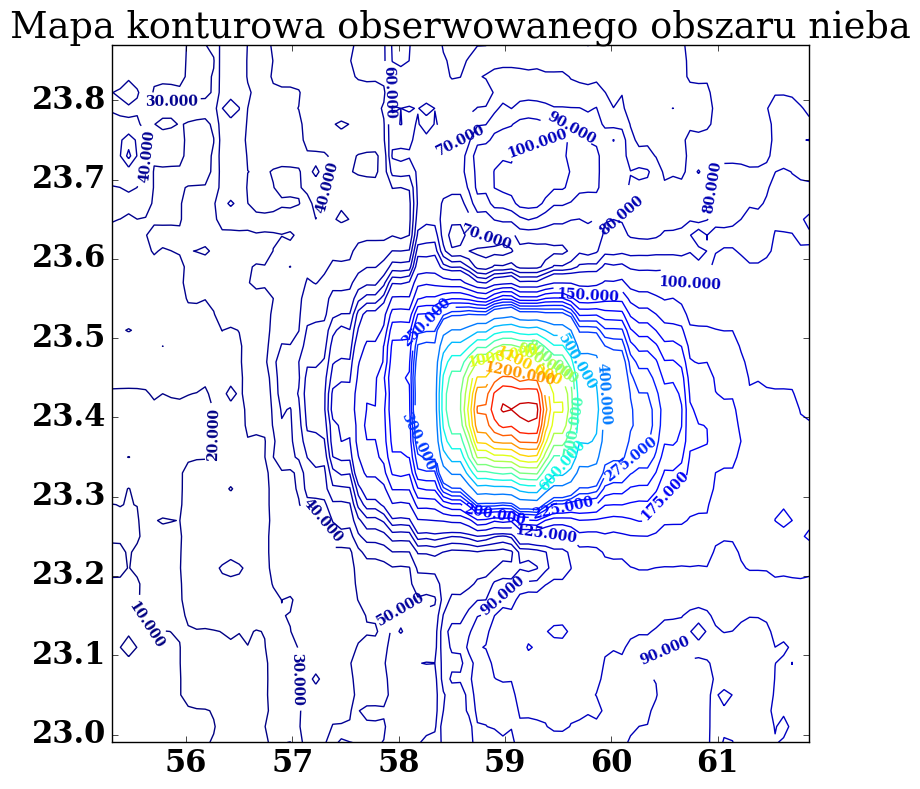

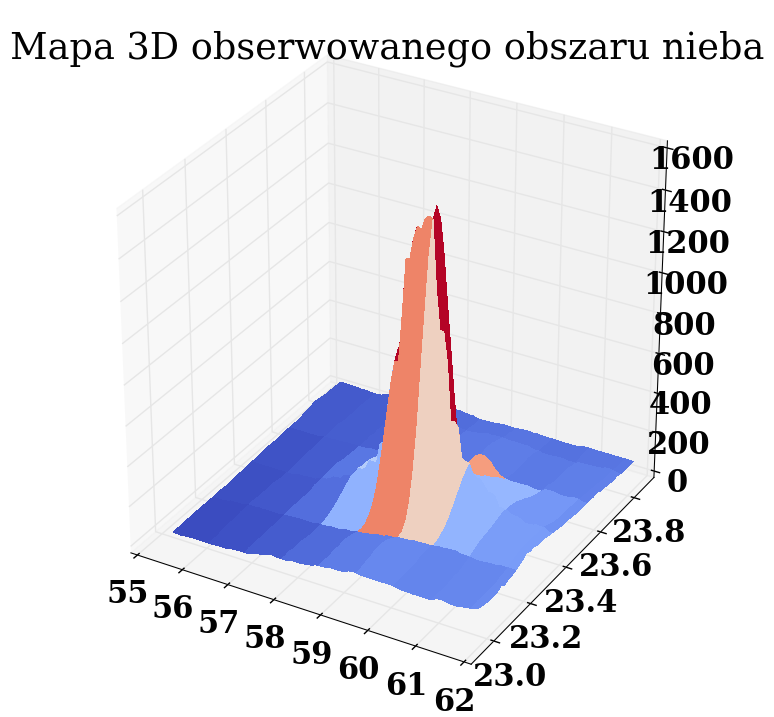

In [13]:
dec_min = 55.3
dec_max = 61.9
ra_min = 22.99
ra_max = 23.88

ind = (dec >= dec_min) & (dec <= dec_max) & (ra >= ra_min) & (ra <= ra_max)

zero_level = min(sig[ind])
print(zero_level)

good_dec = dec[ind]
good_ra = ra[ind]
good_sig = (sig[ind]-zero_level)*p
good_sig_err = (sig[ind]-zero_level)*dp

from math import pi, acos, cos, sin
def distance(dec1, dec2, ra1, ra2):
    cosdist = sin(dec1*pi/180)*sin(dec2*pi/180) + cos(dec1*pi/180)*cos(dec2*pi/180)*cos((ra1 - ra2)/12*pi)
    return acos(cosdist)

#Algorytm jest zdecydowanie nieoptymalny, ale wystarczający na potrzeby zadania
def find_closest(dec, ra, N, decs, ras, sigs):
    dists = []
    for i in range(len(decs)):
        dists.append(distance(decs[i], dec, ras[i], ra))
    sorting = np.argsort(np.array(dists))
    closest = sorting[:N]
    return np.array([[decs[i], ras[i], sigs[i], dists[i]] for i in closest])


def get_sig1(dec, ra, N = 20):
    closest = find_closest(dec, ra, N, good_dec, good_ra, good_sig)
    dists = closest[:, 3]
    sigs = closest[:, 2]
    weights = [1/dist**2 for dist in dists]
    mean = np.sum([weights[i]*sigs[i] for i in range(N)])/np.sum(weights)
    return mean


plt.figure(figsize=(9, 9))
x = np.arange(dec_min, dec_max, 0.08)
y = np.arange(ra_min, ra_max, 0.02)
X, Y = np.meshgrid(x, y, sparse=True)
get_sig_vec = np.vectorize(get_sig1)
Z = get_sig_vec(X, Y)

levels1 = np.arange(300, 1700, 100)
levels2 = np.arange(100, 300, 25)
levels3 = np.arange(10, 100, 10)
levels = np.concatenate((levels3, levels2, levels1))
CS = plt.contour(x, y, Z, levels)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Mapa konturowa obserwowanego obszaru nieba')
plt.show()

from matplotlib import cm
fig = plt.figure(figsize=(9, 9))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.title('Mapa 3D obserwowanego obszaru nieba')
plt.show()



Mniej więcej w centrum mapy wyróżnia się Cassiopeia A. Jest to silne radioźródło i żeby zobaczyć, czy udało nam się trafić w inne radioźródła odejmiemy sygnał pochodzący od Cas A. Uczynimy to odejmując od sygnału wartości dopasowanej wcześniej funkcji Gaussa w całym obszarze mapy.

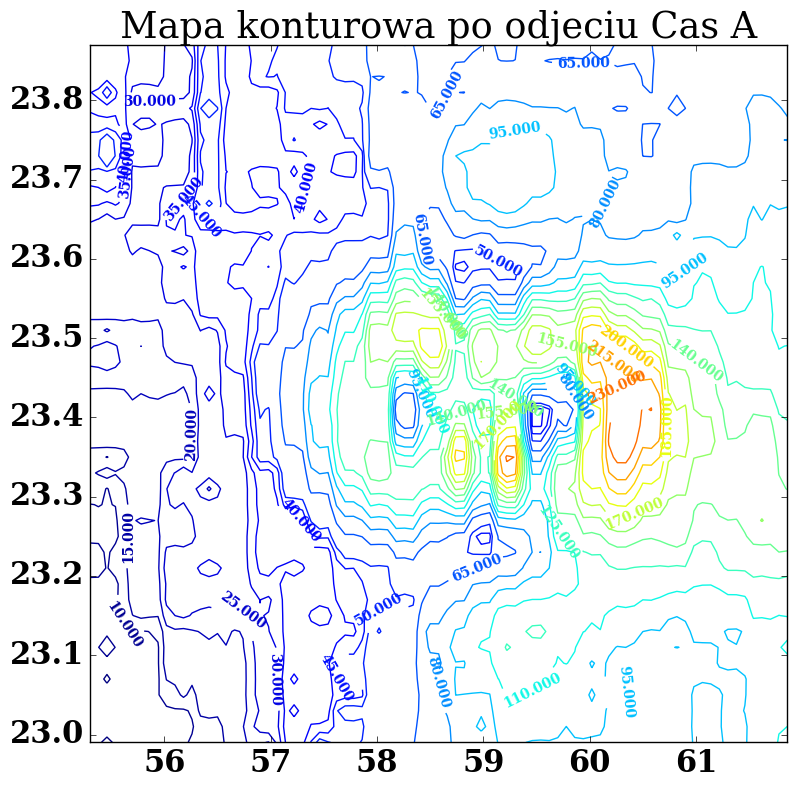

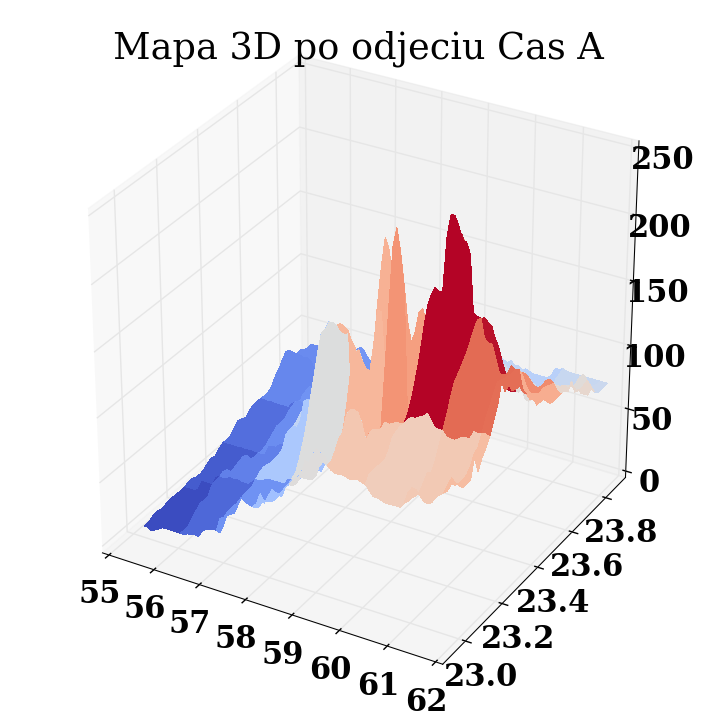

In [14]:
def casa_2dgauss(dec, ra):
    f = fit_params
    return twoD_Gaussian((dec, ra), f[0], f[1], f[2], f[3], f[4], f[5], f[6])

good_sig_minus_casa = []
for i in range(len(good_sig)):
    sig = good_sig[i]
    cas_sig = (casa_2dgauss(good_dec[i], good_ra[i])[0] - fit_params[6])*p
    good_sig_minus_casa.append(sig-cas_sig)
    
good_sig_minus_casa = np.array(good_sig_minus_casa)


def get_sig2(dec, ra, N = 20):
    closest = find_closest(dec, ra, N, good_dec, good_ra, good_sig_minus_casa)
    dists = closest[:, 3]
    sigs = closest[:, 2]
    weights = [1/dist**2 for dist in dists]
    mean = np.sum([weights[i]*sigs[i] for i in range(N)])/np.sum(weights)
    return mean


plt.figure(figsize=(9, 9))
x = np.arange(dec_min, dec_max, 0.08)
y = np.arange(ra_min, ra_max, 0.02)
X, Y = np.meshgrid(x, y, sparse=True)
get_sig_vec = np.vectorize(get_sig2)
Z = get_sig_vec(X, Y)
levels1 = np.arange(50, 300, 15)
levels2 = np.arange(5, 50, 5)
levels = np.concatenate((levels2, levels1))
CS = plt.contour(x, y, Z, levels)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Mapa konturowa po odjeciu Cas A')
plt.show()

from matplotlib import cm
fig = plt.figure(figsize=(9, 9))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.title('Mapa 3D po odjeciu Cas A')
plt.show()
    

Dookoła środka Cas A widzimy pewne miejsca o wyraźnie większej wartości sygnału, ale prawodpodobnie wynikają, że funkcja Gaussa nie opisywała wystarczająco dokładnie rozkładu sygnału.

W niektórych miejsach takich jak około $\delta = +60.2^\circ $ i $\alpha = 23.4^h$
czy około $\delta = +59.5^\circ $ i $\alpha = 23.15^h$ jest podejrzenie, że trafiliśmy na jakieś radioźródło.

Do znalezienia źródeł w obszarze mapy skorzystamy z wyszukiwarki https://heasarc.gsfc.nasa.gov/db-perl/W3Browse/w3table.pl?tablehead=name%3Dradio&Action=More+Options

Po bliższym przyjrzeniu się wygląda na to, że pierwsze "radioźródło" to tylko artefakt wynikający z odejmowania funkcji Gaussa. Poziomy "zerowy" w deklinacji po jednej i drugiej stronie Cas A nie są równe, co utrudnia dopasowanie funkcji gaussowskiej (widać to było wyraźnie w sprawozdaniu z ćw. 2A). 

Ponadto wyszukiwarka znajduje źródła tylko o co najmniej 3 rzędy słabsze od Cas A. Jak wiemy z ćw. 2B takie źródła byłyby słabsze od listków bocznych pochodzących ze splotu charakterystyki kierunkowej radioteleskopu ze strumieniem Cas A. Tym samym źródłem wyraźnie widocznego na mapie sygnału nie mogą być znajdujące się w katalogach radioźródła. 

Należy zauważyć, że dokonujemy obserwacji na pewnej bardzo charakterystycznej częstostliwości $1420 MHz$. Jest to częstotliwość odpowiadająca promieniowaniu neturalnego wodoru HI. Jeżeli tak jest, to obserwowane wartości powinny odpowiadać rozkładowi HI w Drodze Mlecznej. 

Rozkład HI był jest dostępny m.in. w pracy "The Effelsberg-Bonn HI Survey: Milky Way gas. First data release", Winkel, B., et al. 2016, Astron. Astrophys., 585, A41 ADS. Więcej szczegółów i dane: https://lambda.gsfc.nasa.gov/product/foreground/ebhis_info.cfm

Na podstawie danych z powyższej publikacji stworzono poniższą mapę przedstawiającą gęstość kolumnową wodoru w interesującym nas obszarze.

![caption](files/mapkaHI.png)


Mapa ta dość dobrze odzwierciedla to co zaobserwowaliśmy. Nie jest to idealne dopasowanie, ale musimy pamiętać, że ze względu na rozmiar wiązki radioteleskopu nasz sygnał jest bardziej rozmyty niż w powyższej publikacji. Ponadto pewne zniekształcenia wprowadza odjęcie niedokładnie dopasowanej funkcji Gaussa.

## Podsumowanie

W ćwiczeniu udało nam się zaobserwować strumień pochodzący od Cassiopei A, a także od neturalnego wodoru w obszarze Drogi Mlecznej. Gdybyśmy chcieli obserwować inne radioźródła w tej okolicy najlepiej byłoby wykonywać obserwacje dla innej długości fali.

Ze względu na brak automatyzacji radioteleskopu ćwiczenie było żmudne, acz pouczające. Ciekawym byłoby przeskanowanie obszaru Drogi Mlecznej w większej odpowiedniej odległości od Cassiopei A i innych silnych radioźródeł. Pozwalają one na kalibrację, ale utrudniają obserwację ich otoczenia. Niestety jedynym wyróżniającym się w badanym obszarze punktowym radioźródłem była Cas A. 